In [1]:
# Import necessary libraries
import pyreadr
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
import plotly.graph_objects as go
import numpy as np
import streamlit as st
from pycirclize import Circos
import matplotlib.pyplot as plt
import seaborn as sns
import liana as li
import scanpy as sc
from anndata import AnnData
import pandas as pd
from liana.mt import rank_aggregate
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
hf_male_8weeks = sc.read_h5ad('../exported_data/pvat_8weeks_hf_male.h5ad')
hf_male_8weeks

AnnData object with n_obs × n_vars = 9608 × 20743
    obs: 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'scDblFinder_score', 'scDblFinder_class', 'Sample', 'tissue', 'diet', 'time', 'sex', 'batch', 'sample_type', 'rat_id', 'weight_3W', 'weight_10W', 'weight_17W', 'weight_24W', 'MAP_7W', 'systolic_bp_7W', 'MAP_9W', 'systolic_bp_9W', 'MAP_16W', 'systolic_bp_16W', 'MAP_24W', 'systolic_bp_24W', 'doublet', 'celltype', 'celltype_broad'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cellchat_interaction_table_count', 'cellchat_res', 'cellchat_res_filtered', 

In [3]:
np.unique(hf_male_8weeks.obs['celltype_broad'])

array(['Adipocytes', 'Endothelial_Cells', 'Fibroblasts', 'Immune_Cells',
       'Mesothelial_Cells', 'Neuronal_Cells', 'Pericytes', 'SMCs'],
      dtype=object)

In [4]:
# Load RDS file using rpy2, needed for interaction data
filepath = '../figures/exported_results/nichenet/pvat_8weeks_hf_male_nichenet.rds'
readRDS = ro.r['readRDS']
pvat_cci = readRDS(filepath)

In [18]:
pvat_cci

<rpy2.robjects.vectors.ListVector object at 0x158d5f590> [19]
R classes: ('list',)
[ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV..., ..., ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV...]
<rpy2.robjects.vectors.ListVector object at 0x158d5f590> [19]
R classes: ('list',)
[ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV..., ..., ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV...]
<rpy2.robjects.vectors.ListVector object at 0x158d5f590> [19]
R classes: ('list',)
[ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV..., ..., ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV...]
<rpy2.robjects.vectors.ListVector object at 0x158d5f590> [19]
R classes: ('list',)
[ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV..., ..., ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV...]
<rpy2.robjects.vectors.ListVector object at 0x158d5f590> [19]
R classes: ('list',)
[ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV..., ..., ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV...]
...
<rpy2.robjects.vectors.ListVector object at 0x158d5f590> [19]
R classes: ('list',)
[ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV..., ..., ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV...]
<rpy2.robjects.vectors.ListVector object at 0x158d5f590> [19]
R classes: ('list',)
[ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV..., ..., ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV...]
<rpy2.robjects.vectors.ListVector object at 0x158d5f590> [19]
R classes: ('list',)
[ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV..., ..., ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV...]
<rpy2.robjects.vectors.ListVector object at 0x158d5f590> [19]
R classes: ('list',)
[ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV..., ..., ListSexpV..., ListSexpV..., ListSexpV..., ListSexpV...]

In [5]:
source_labels = ['Adipocytes', 'Endothelial_Cells', 'Fibroblasts', 'Immune_Cells',
       'Mesothelial_Cells', 'Neuronal_Cells', 'Pericytes', 'SMCs']
target_labels = ['Adipocytes', 'Endothelial_Cells', 'Fibroblasts', 'Immune_Cells',
       'Mesothelial_Cells', 'Neuronal_Cells', 'Pericytes', 'SMCs']

In [6]:
cell_pair_interactions = []
for source_cell in source_labels:
    for target_cell in target_labels:
            cell_pair_string = f'{source_cell.replace(" ", "")}2{target_cell.replace(" ", "")}'
            cell_one2cell_two = pvat_cci.rx2(cell_pair_string)
            ligand_receptor = pandas2ri.rpy2py(cell_one2cell_two.rx2('p_ligand_receptor_network'))
            long_format = ligand_receptor.T.stack().reset_index().set_axis('ligand_complex receptor_complex weight'.split(), axis=1)
            long_format['source'] = source_cell
            long_format['target'] = target_cell
        
            cell_pair_interactions.append(long_format)

nichenet_cci = pd.concat(cell_pair_interactions)

In [8]:
pd.set_option('display.max_rows', None)
heatmap_df = nichenet_cci[(nichenet_cci['source'] == "Adipocytes") & (nichenet_cci['target'] == "Endothelial_Cells") & (nichenet_cci['weight'] > 0)]
heatmap_df

,ligand_complex,receptor_complex,weight,source,target
42,Col4a2,Itga1,0.516071,Adipocytes,Endothelial_Cells
43,Col4a2,Itgb1,0.485124,Adipocytes,Endothelial_Cells
47,Col4a2,Itgb3,0.700674,Adipocytes,Endothelial_Cells
92,Col7a1,Itga1,0.282470,Adipocytes,Endothelial_Cells
93,Col7a1,Itgb1,0.485124,Adipocytes,Endothelial_Cells
142,Col5a3,Itga1,0.516071,Adipocytes,Endothelial_Cells
143,Col5a3,Itgb1,0.485124,Adipocytes,Endothelial_Cells
192,Col5a1,Itga1,0.516071,Adipocytes,Endothelial_Cells
193,Col5a1,Itgb1,0.485124,Adipocytes,Endothelial_Cells
242,Col27a1,Itga1,0.282470,Adipocytes,Endothelial_Cells


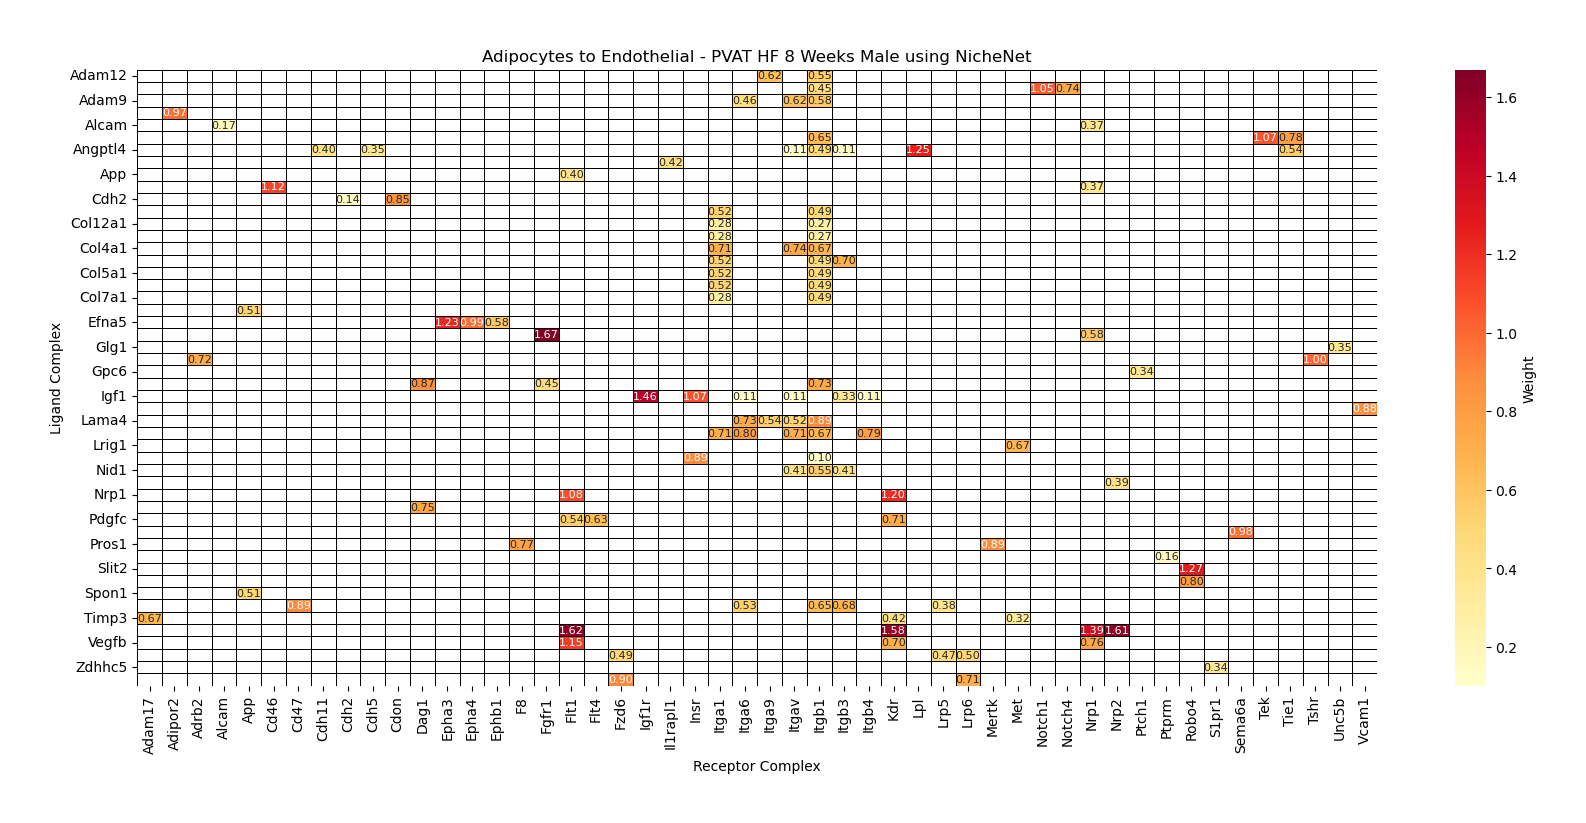

In [17]:
heatmap_data = heatmap_df.pivot(index="ligand_complex", columns="receptor_complex", values="weight")

fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd", fmt=".2f", annot_kws={"size": 8}, 
            cbar_kws={'label': 'Weight'}, linecolor='black', linewidths=0.5)
plt.title("Adipocytes to Endothelial - PVAT HF 8 Weeks Male using NicheNet")
plt.xlabel("Receptor Complex")
plt.ylabel("Ligand Complex")
plt.show()

In [12]:
nichenet_cci = nichenet_cci[nichenet_cci['weight']>0]
nichenet_cci

,ligand_complex,receptor_complex,weight,source,target
12,Col4a1,Itgav,0.744113,Adipocytes,Adipocytes
13,Col4a1,Itga1,0.709254,Adipocytes,Adipocytes
14,Col4a1,Itgb1,0.666722,Adipocytes,Adipocytes
46,Lamc1,Itgav,0.709021,Adipocytes,Adipocytes
47,Lamc1,Itga1,0.709254,Adipocytes,Adipocytes
...,...,...,...,...,...
1200,Jag1,Notch3,0.844486,SMCs,SMCs
1235,Fgf12,Scn4a,0.406481,SMCs,SMCs
1260,Copa,Sort1,0.509926,SMCs,SMCs
1294,Bmp1,Bmpr2,0.546225,SMCs,SMCs


In [13]:
hf_male_8weeks.uns['nichenet_lr_res'] = nichenet_cci

In [14]:
#hf_male_8weeks.write('../exported_data/pvat_8weeks_control_male.h5ad')

## NichetNet Plots

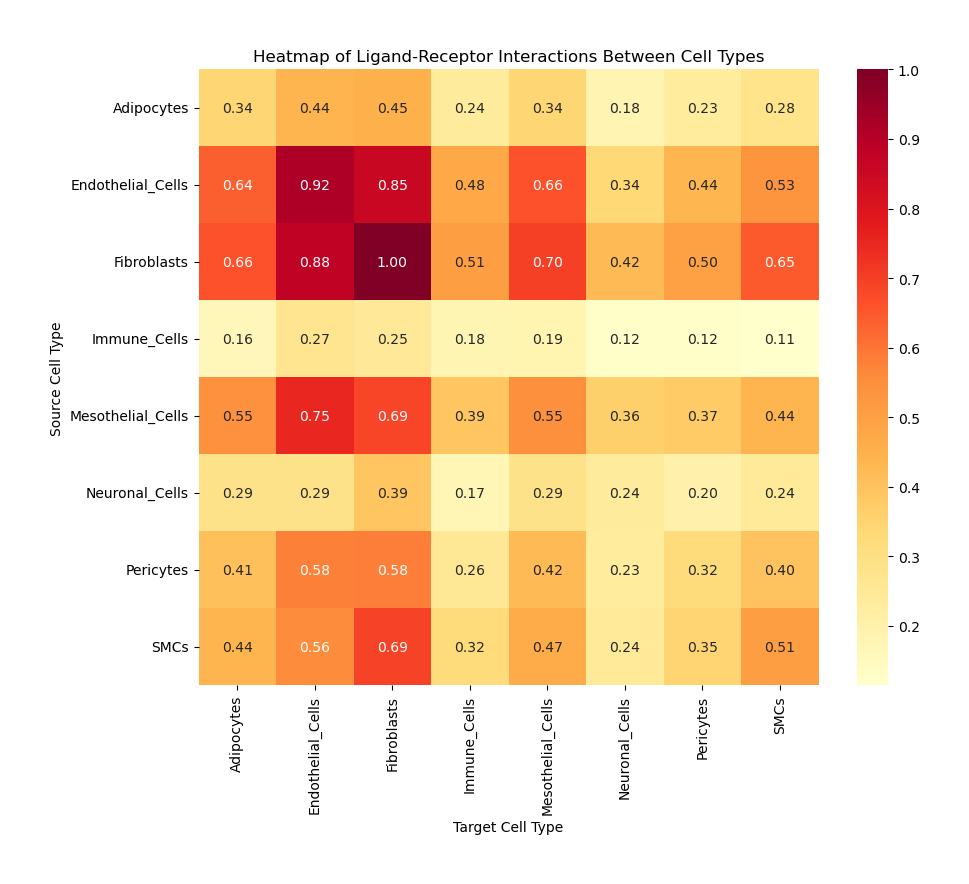

In [15]:
interaction_pivot_table_nichenet = hf_male_8weeks.uns['nichenet_lr_res'].groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).size().groupby(['source', 'target']).sum().unstack(fill_value=0)
interaction_pivot_table_nichenet_norm = interaction_pivot_table_nichenet / interaction_pivot_table_nichenet.max().max()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_pivot_table_nichenet_norm, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()

In [16]:
hf_male_8weeks.uns['nichenet_interaction_table_count'] = interaction_pivot_table_nichenet

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


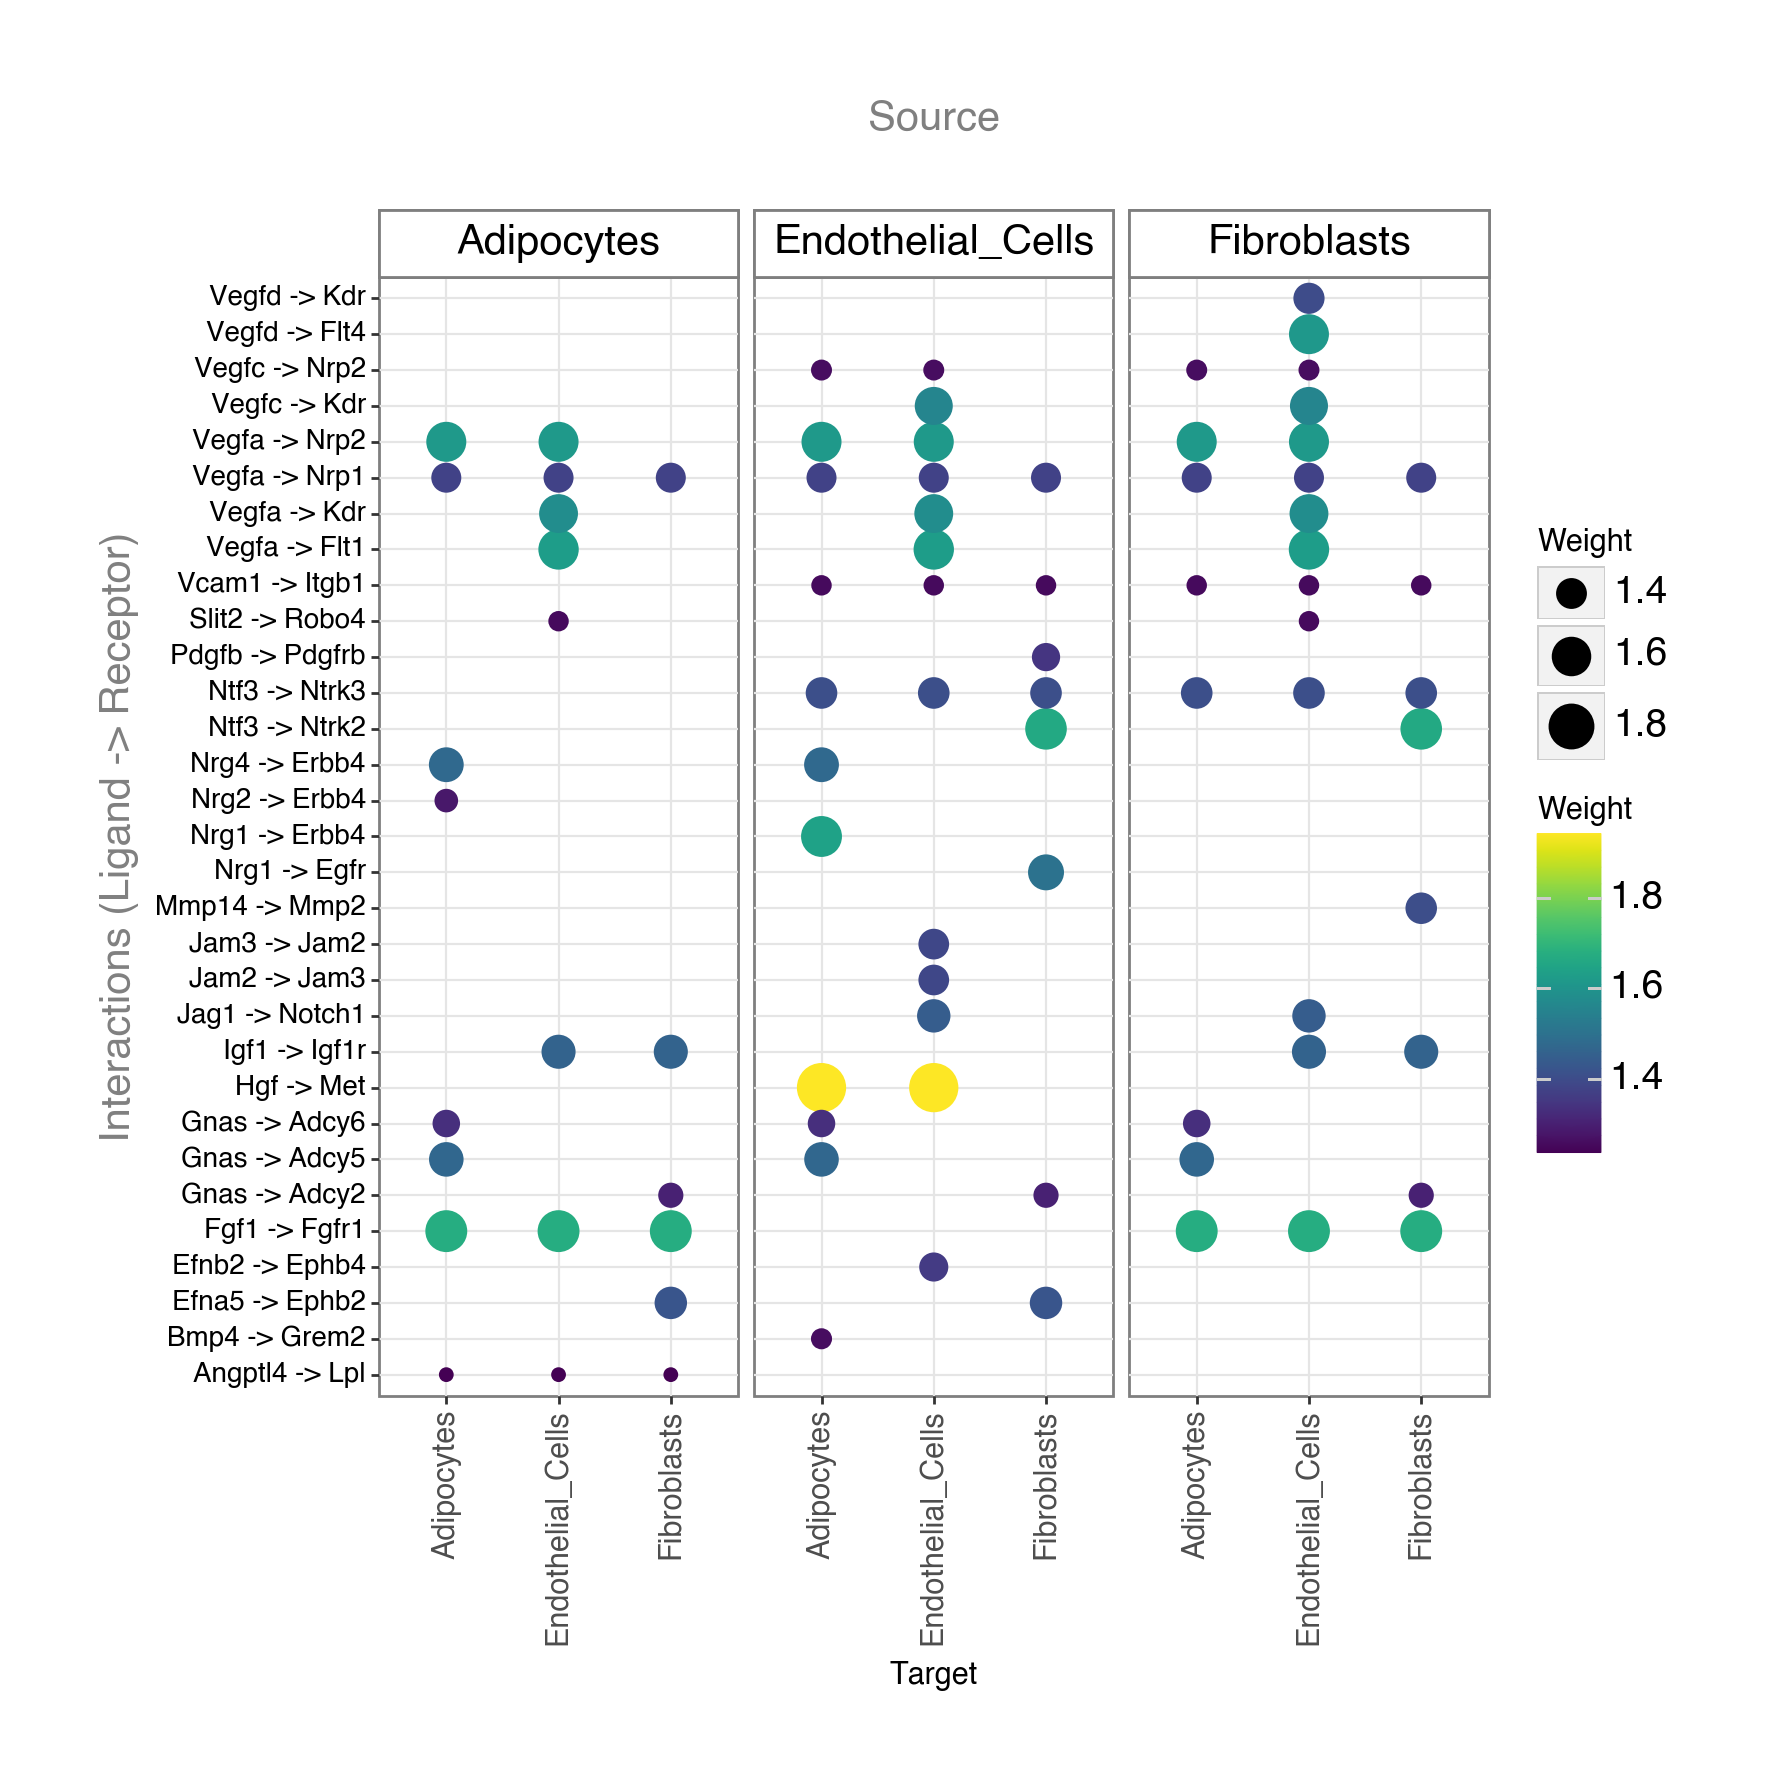

<Figure Size: (800 x 800)>

In [12]:
nichenet_df = hf_male_8weeks.uns['nichenet_lr_res']
hf_male_8weeks.uns['nichenet_res_filtered'] = nichenet_df[nichenet_df['weight']>1.25]
nichenet_plot = li.pl.dotplot(adata = hf_male_8weeks,
              colour='weight',
              size='weight',
              source_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              target_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              figure_size=(8, 8),
              uns_key='nichenet_res_filtered' # uns_key to use, default is 'liana_res'
             )
nichenet_plot

## CellChat

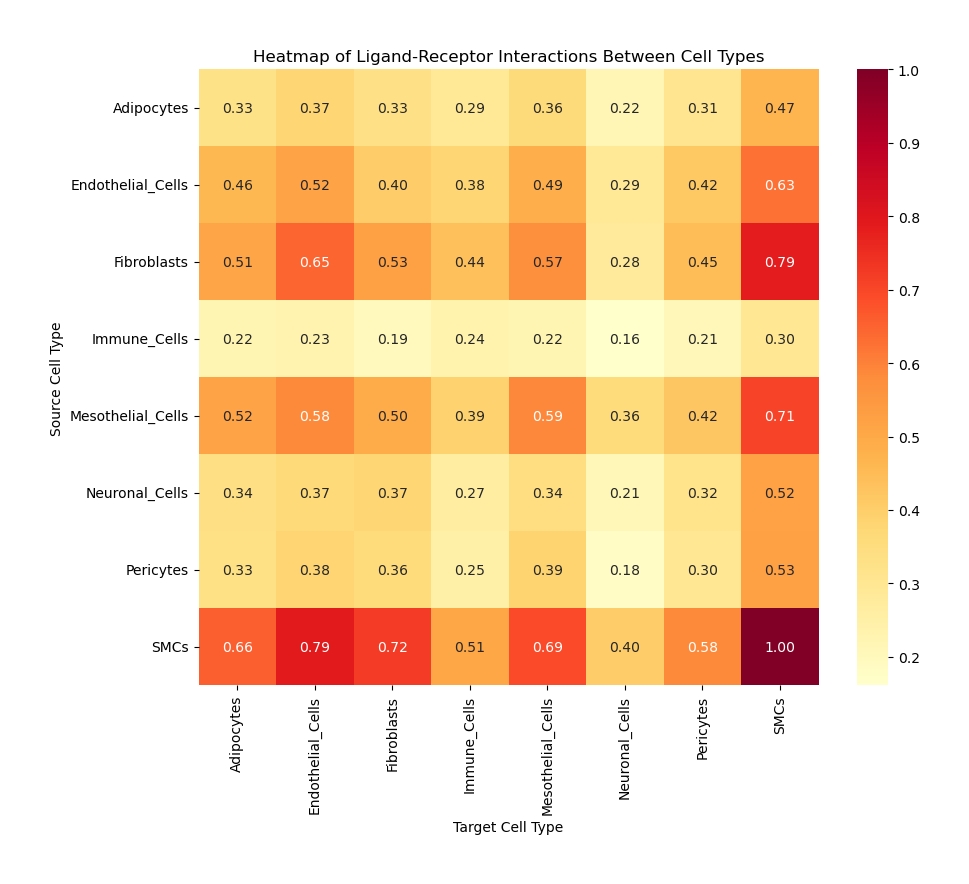

In [17]:
interaction_pivot_table_cellchat = hf_male_8weeks.uns['cellchat_res'].groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).size().groupby(['source', 'target']).sum().unstack(fill_value=0)
interaction_pivot_table_cellchat_norm = interaction_pivot_table_cellchat / interaction_pivot_table_cellchat.max().max()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_pivot_table_cellchat_norm, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()

In [10]:
cellchat_df = hf_male_8weeks.uns['cellchat_res']

pd.set_option('display.max_rows', None)
cellchat_df[(cellchat_df['source'] == "Adipocytes") & (cellchat_df['target'] == "Endothelial_Cells") & (cellchat_df['cellchat_pvals'] <= 0.05)]

,ligand,ligand_complex,ligand_props,ligand_trimean,mat_max,receptor,receptor_complex,receptor_props,receptor_trimean,source,target,lr_probs,cellchat_pvals
1097,Vegfa,Vegfa,0.955981,0.021484,256.0,Nrp2,Nrp2,0.297945,0.000977,Adipocytes,Endothelial_Cells,0.000042,0.000
1150,Vegfa,Vegfa,0.955981,0.021484,256.0,Itga9,Itga9,0.259132,0.000977,Adipocytes,Endothelial_Cells,0.000042,0.000
1190,Vegfa,Vegfa,0.955981,0.021484,256.0,Kdr,Flt1_Kdr,0.375571,0.000977,Adipocytes,Endothelial_Cells,0.000042,0.000
1133,Vegfa,Vegfa,0.955981,0.021484,256.0,Itgb1,Itgb1,0.337900,0.000977,Adipocytes,Endothelial_Cells,0.000042,0.000
1127,Lama4,Lama4,0.889563,0.013672,256.0,Itgb1,Itga6_Itgb1,0.337900,0.000977,Adipocytes,Endothelial_Cells,0.000027,0.000
1129,Lama4,Lama4,0.889563,0.013672,256.0,Itgb1,Itga9_Itgb1,0.337900,0.000977,Adipocytes,Endothelial_Cells,0.000027,0.000
1110,Col4a1,Col4a1,0.730751,0.006836,256.0,Itgb1,Itga1_Itgb1,0.337900,0.000977,Adipocytes,Endothelial_Cells,0.000013,0.000
1112,Col4a1,Col4a1,0.730751,0.006836,256.0,Itgb1,Itga9_Itgb1,0.337900,0.000977,Adipocytes,Endothelial_Cells,0.000013,0.000
1141,Col7a1,Col7a1,0.644735,0.004883,256.0,Itgb1,Itga1_Itgb1,0.337900,0.000977,Adipocytes,Endothelial_Cells,0.000010,0.000
1195,Farp2,Farp2,0.351221,0.000977,256.0,Plxna2,Plxna2,0.615297,0.004150,Adipocytes,Endothelial_Cells,0.000008,0.000


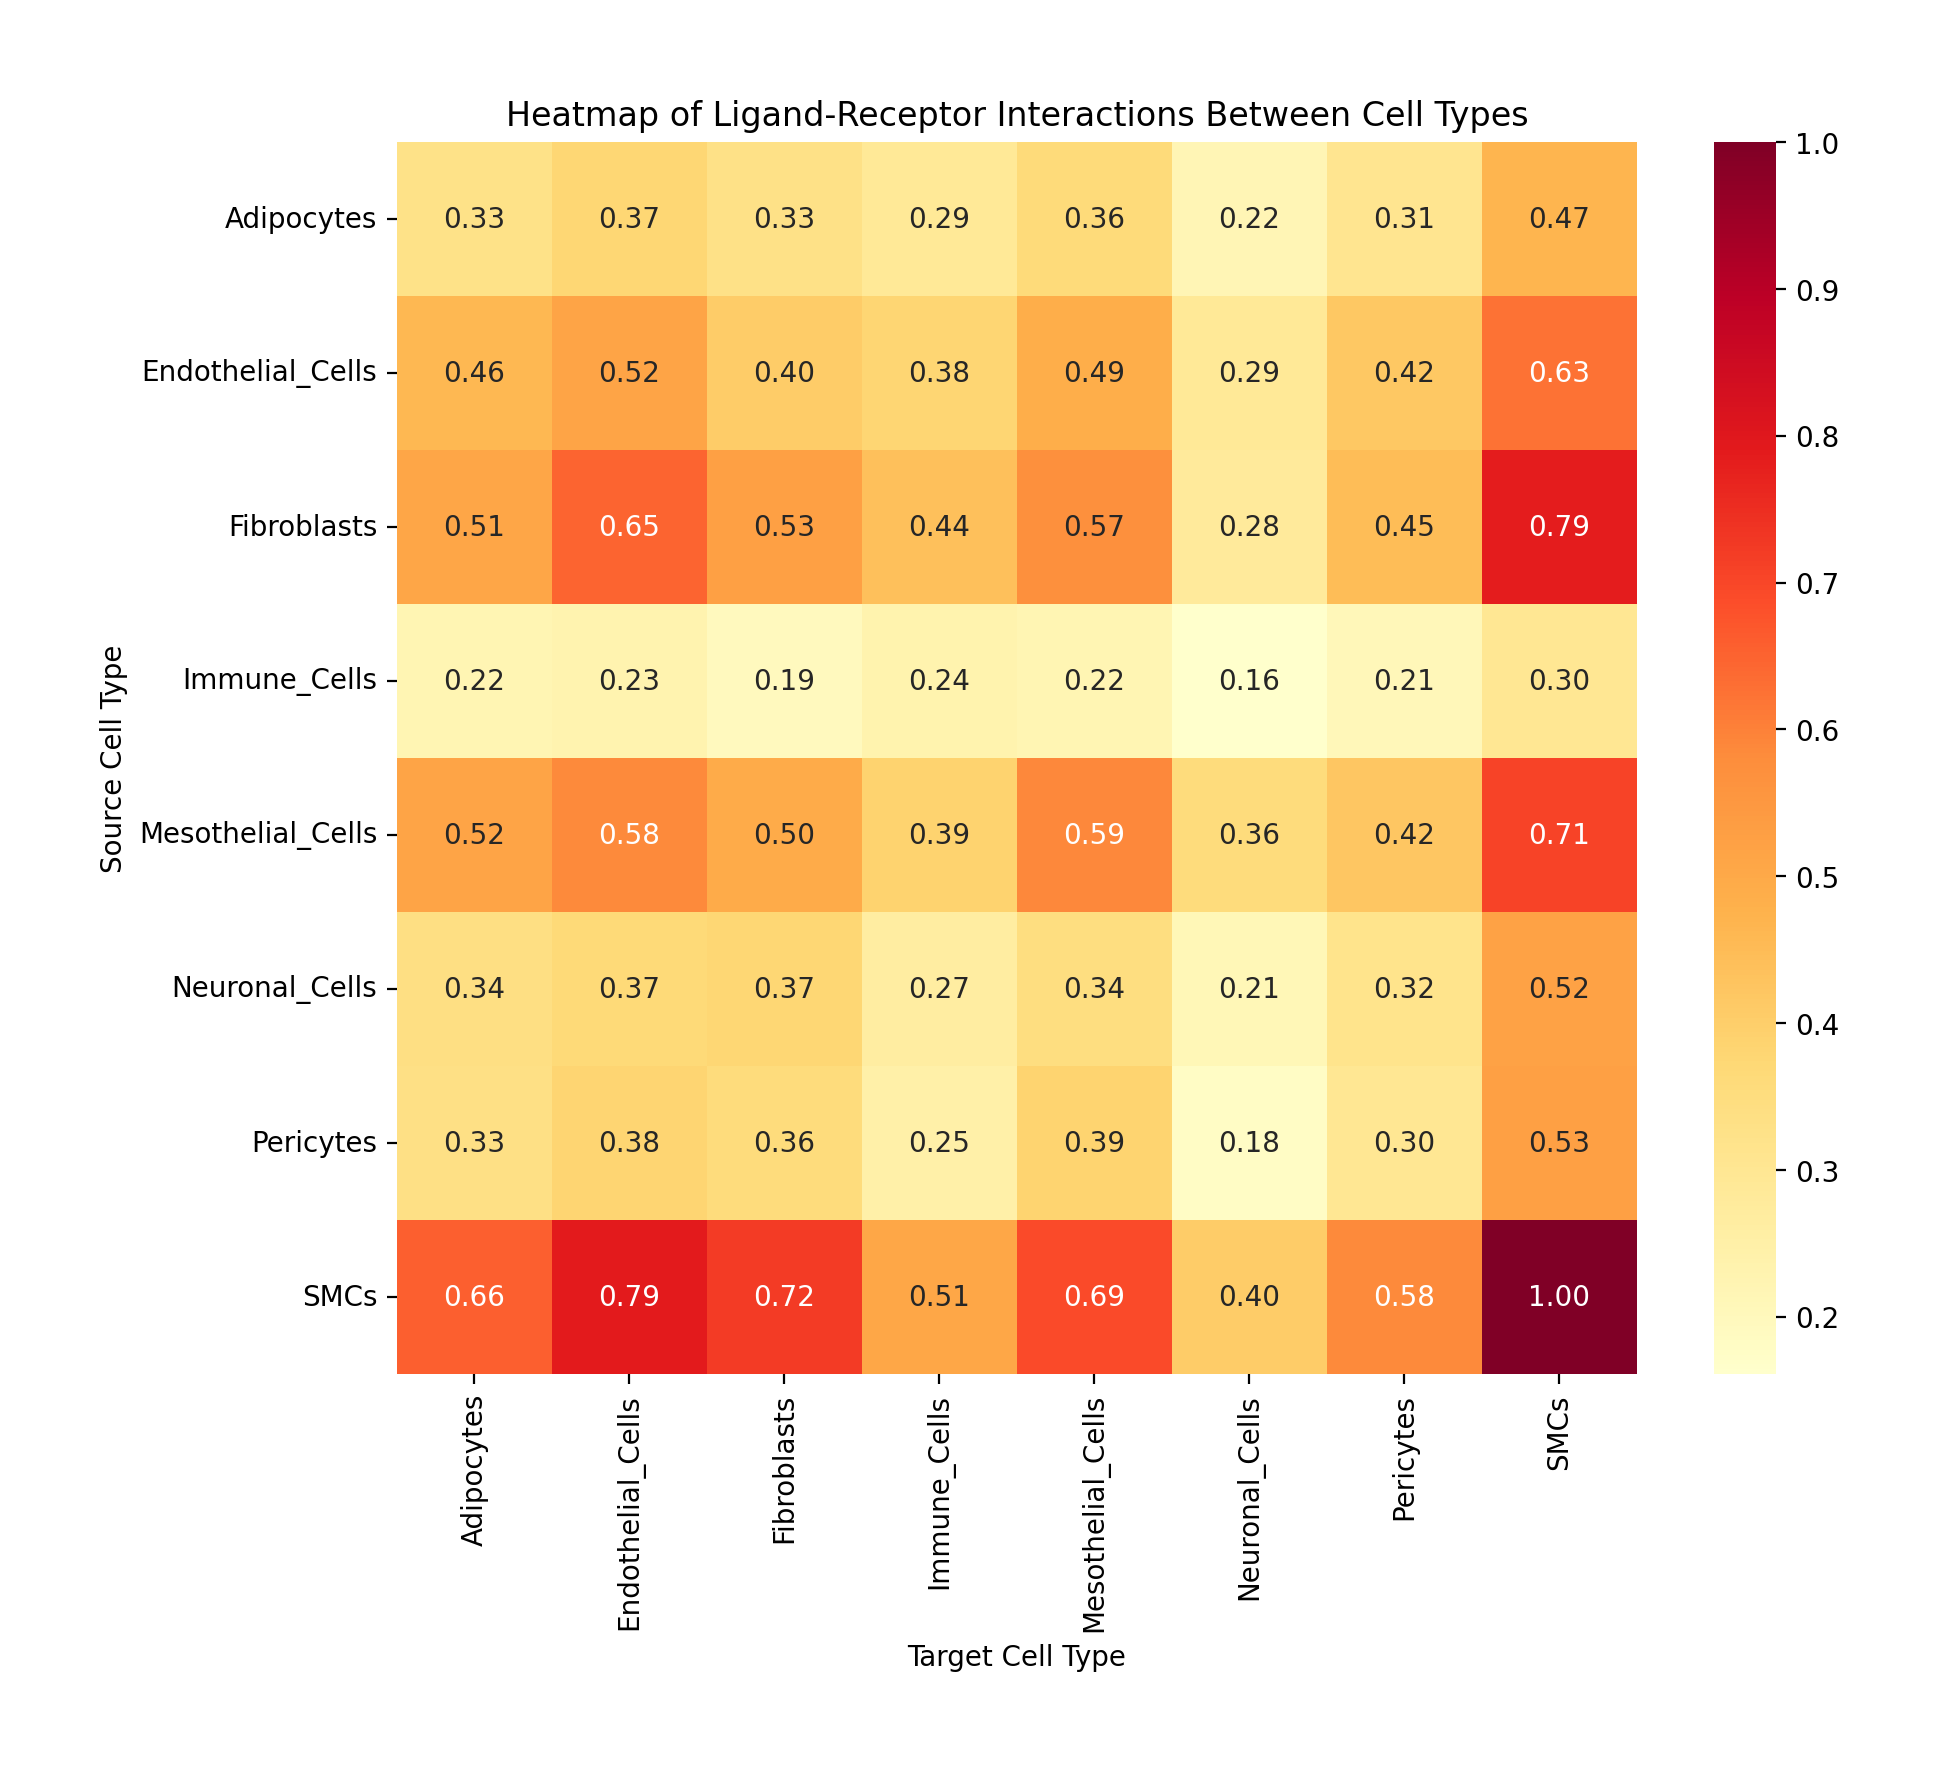

In [33]:
interaction_pivot_table_cellchat = hf_male_8weeks.uns['cellchat_res'].groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).size().groupby(['source', 'target']).sum().unstack(fill_value=0)
interaction_pivot_table_cellchat_norm = interaction_pivot_table / interaction_pivot_table.max().max()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_pivot_table_cellchat_norm, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()

In [18]:
hf_male_8weeks.uns['cellchat_interaction_table_count'] = interaction_pivot_table_cellchat

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


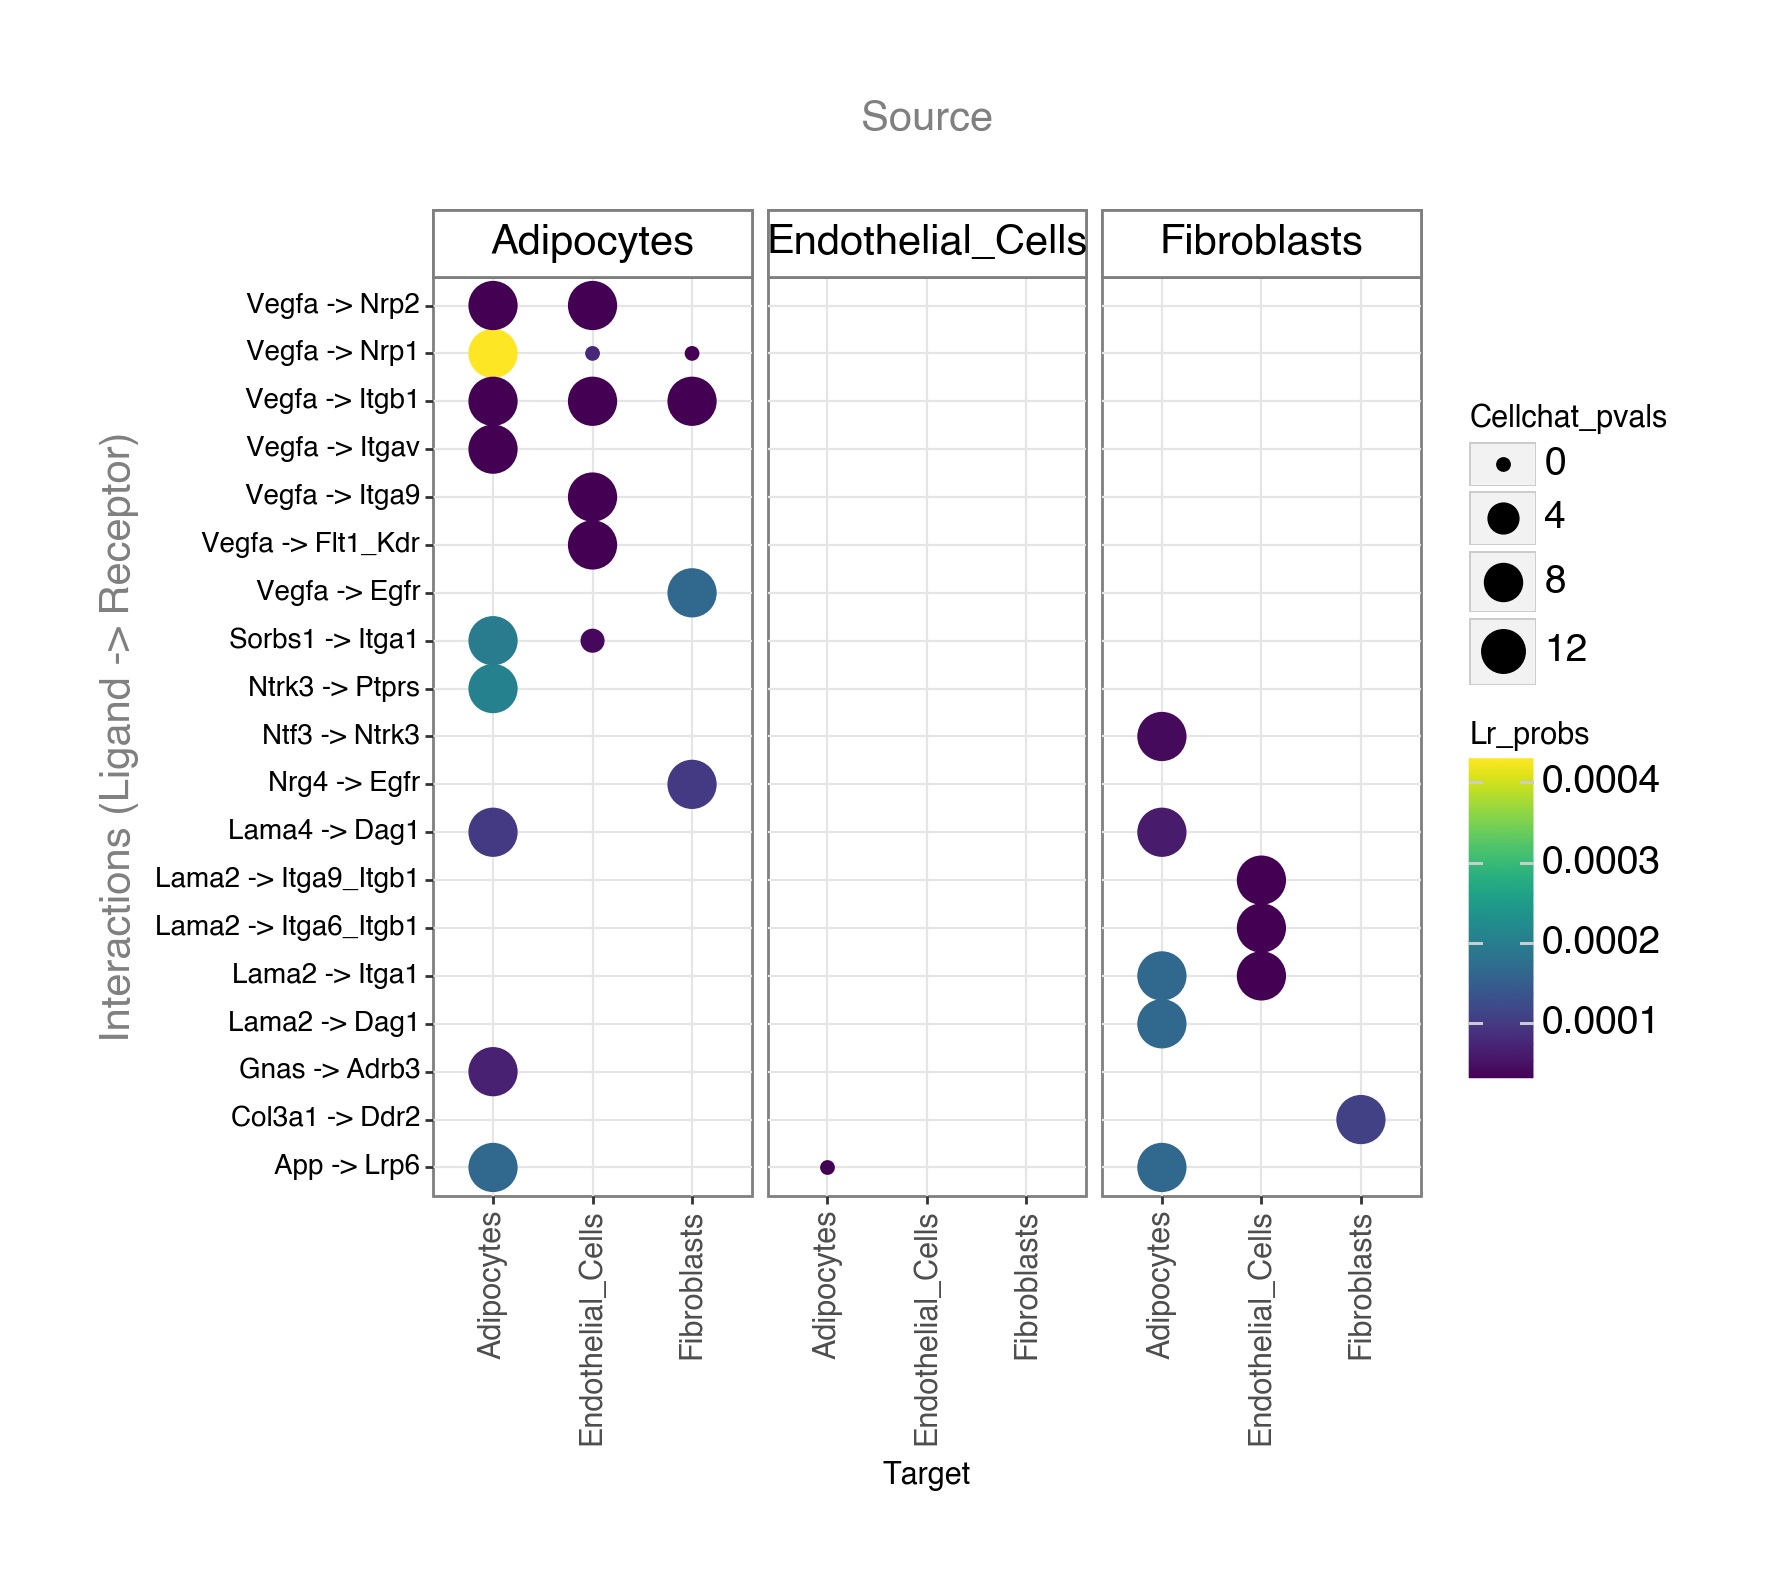

<Figure Size: (800 x 700)>

In [18]:
cellchat_df = hf_male_8weeks.uns['cellchat_res']
hf_male_8weeks.uns['cellchat_res_filtered'] = cellchat_df[cellchat_df['lr_probs']>0.00004]
cellchat_plot = li.pl.dotplot(adata = hf_male_8weeks,
              colour='lr_probs',
              size='cellchat_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              target_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              figure_size=(8, 7),
              # we filter the pvals column to <= 0.05
              filter_fun=lambda x: x['cellchat_pvals'] <= 0.05,
              uns_key='cellchat_res_filtered' # uns_key to use, default is 'liana_res'
             )
cellchat_plot

## CellPhonedb

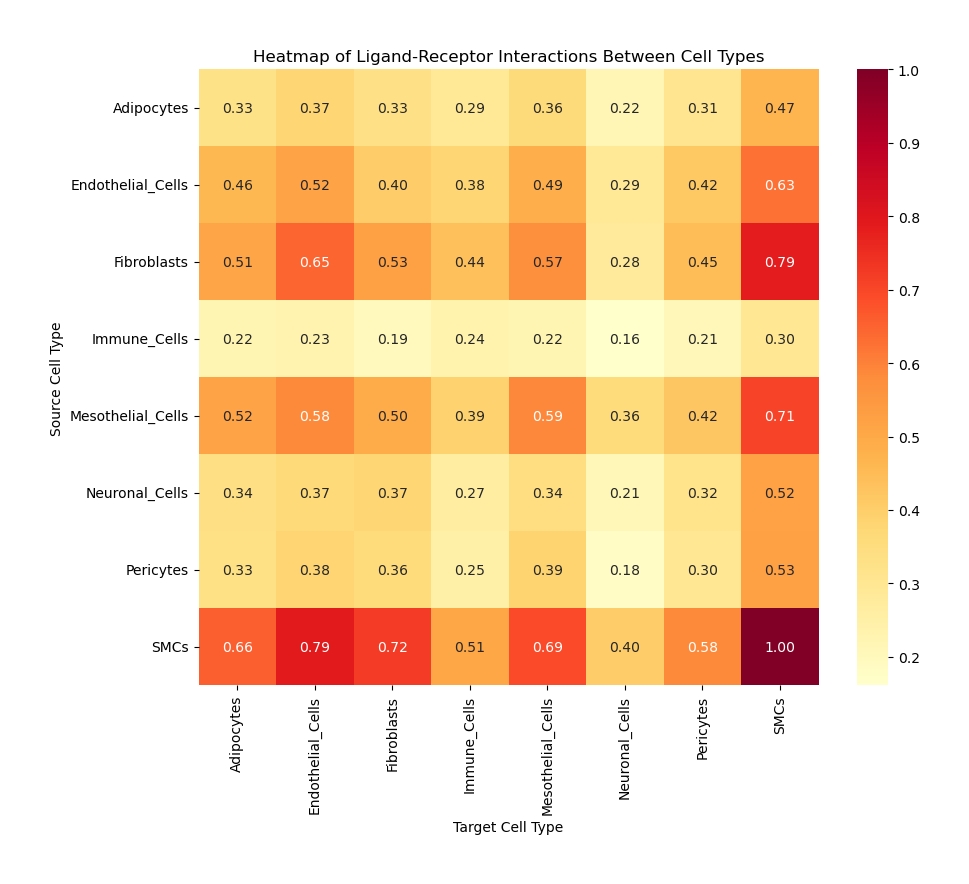

In [19]:
interaction_pivot_table_cellphonedb = hf_male_8weeks.uns['cellphonedb_res'].groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).size().groupby(['source', 'target']).sum().unstack(fill_value=0)
interaction_pivot_table_cellphonedb_norm = interaction_pivot_table_cellphonedb / interaction_pivot_table_cellphonedb.max().max()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(interaction_pivot_table_cellphonedb_norm, annot=True, cmap="YlOrRd", fmt=".2f", ax=ax)
ax.set_title('Heatmap of Ligand-Receptor Interactions Between Cell Types')
ax.set_ylabel('Source Cell Type')
ax.set_xlabel('Target Cell Type')
plt.show()

In [11]:
cellphone_df = hf_male_8weeks.uns['cellphonedb_res']

pd.set_option('display.max_rows', None)
cellphone_df[(cellphone_df['source'] == "Adipocytes") & (cellphone_df['target'] == "Endothelial_Cells") & (cellphone_df['cellphone_pvals'] <= 0.05)]

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
1154,Sorbs1,Sorbs1,7.917188,0.933893,Itga1,Itga1,0.769405,0.405251,Adipocytes,Endothelial_Cells,4.343297,0.000
1186,Vegfa,Vegfa,6.361763,0.955981,Nrp1,Nrp1,1.343604,0.484018,Adipocytes,Endothelial_Cells,3.852684,0.000
1190,Vegfa,Vegfa,6.361763,0.955981,Kdr,Flt1_Kdr,0.861871,0.375571,Adipocytes,Endothelial_Cells,3.611817,0.000
1150,Vegfa,Vegfa,6.361763,0.955981,Itga9,Itga9,0.756849,0.259132,Adipocytes,Endothelial_Cells,3.559306,0.000
1097,Vegfa,Vegfa,6.361763,0.955981,Nrp2,Nrp2,0.688355,0.297945,Adipocytes,Endothelial_Cells,3.525059,0.000
1133,Vegfa,Vegfa,6.361763,0.955981,Itgb1,Itgb1,0.544519,0.337900,Adipocytes,Endothelial_Cells,3.453141,0.000
1183,Efna5,Efna5,6.501256,0.831233,Epha4,Epha4,0.294520,0.139269,Adipocytes,Endothelial_Cells,3.397888,0.000
1158,Vegfa,Vegfa,6.361763,0.955981,Itgav,Itgav,0.228310,0.157534,Adipocytes,Endothelial_Cells,3.295037,0.000
1127,Lama4,Lama4,4.921396,0.889563,Itgb1,Itga6_Itgb1,0.544519,0.337900,Adipocytes,Endothelial_Cells,2.732958,0.000
1129,Lama4,Lama4,4.921396,0.889563,Itgb1,Itga9_Itgb1,0.544519,0.337900,Adipocytes,Endothelial_Cells,2.732958,0.000


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


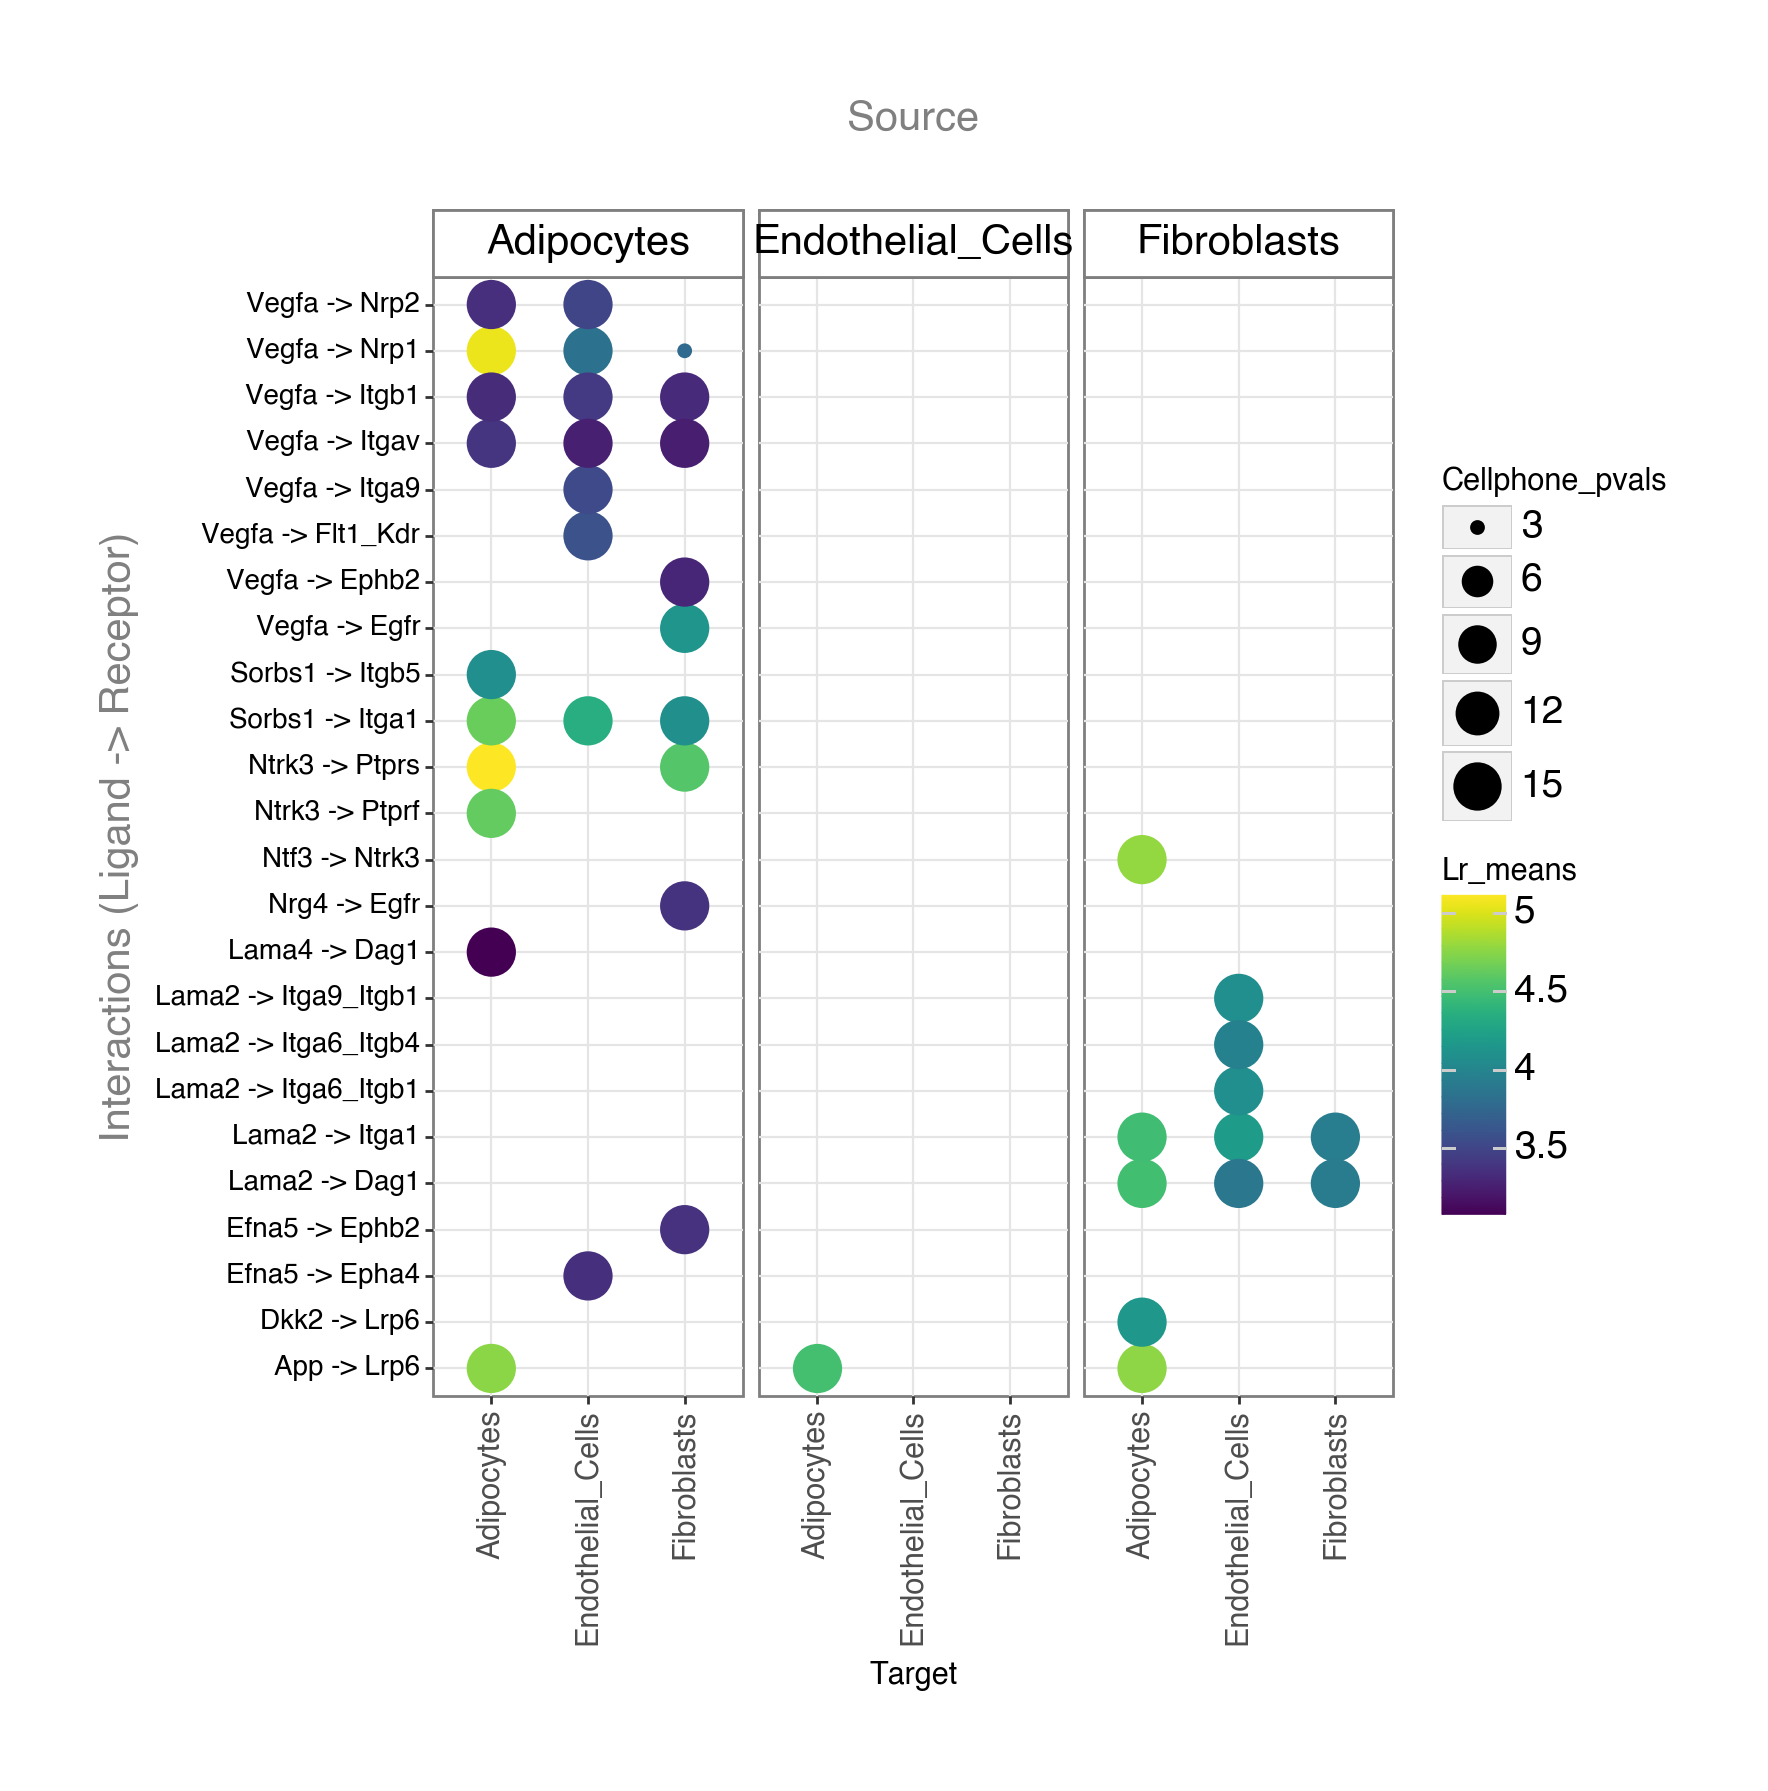

<Figure Size: (800 x 800)>

In [20]:
cellphonedb_db = hf_male_8weeks.uns['cellphonedb_res']
hf_male_8weeks.uns['cellphonedb_res_filtered'] = cellphonedb_db[cellphonedb_db['lr_means']>3]

li.pl.dotplot(adata = hf_male_8weeks,
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              target_labels=['Adipocytes', 'Endothelial_Cells', 'Fibroblasts'],
              figure_size=(8, 8),
              # we filter the pvals column to <= 0.05
              filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
              uns_key='cellphonedb_res_filtered' # uns_key to use, default is 'liana_res'
             )

In [20]:
hf_male_8weeks.uns['cellphonedb_interaction_table_count'] = interaction_pivot_table_cellphonedb

In [21]:
hf_male_8weeks.write('../exported_data/pvat_8weeks_hf_male.h5ad')